In [1]:
import os
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer
from tqdm.auto import tqdm
import math
from pathlib import Path
import math

from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config
from modular_transformers.models import components
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature

from transformer_xray.perturb_utils import *

import matplotlib.pyplot as plt
import random
import numpy as np

from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader, Dataset

import pickle

from scikitplot.decomposition import plot_pca_2d_projection, plot_pca_component_variance
from sklearn.decomposition import PCA

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
class LMDataset(Dataset):
    def __init__(self, inputs, attn_mask=None, labels=None):
        #cast to tensors if not already tensors
        if not torch.is_tensor(inputs):
            inputs = torch.tensor(inputs)
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels)
        if attn_mask is not None and not torch.is_tensor(attn_mask):
            attn_mask = torch.tensor(attn_mask)
            
        self.inputs = inputs
        self.attn_mask = attn_mask
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.labels is None:
            item = {
                'input_ids': self.inputs[idx],
                'attention_mask': self.attn_mask[idx]}
        elif self.attn_mask is None:
            item = {
                'input_ids': self.inputs[idx],
                'labels': self.labels[idx]
            }
        else:
            item = {
                'input_ids': self.inputs[idx],
                'attention_mask': self.attn_mask[idx],
                'labels': self.labels[idx]
            }
        return item

In [45]:
path = "/om2/user/jackking/modular_transformers/scripts/dimensionality_reduction"
datatype = "natural_language"
data = pickle.load(open(f"{path}/data/{datatype}/train_data_natural.pkl", 'rb'))#[:5000]

batch_size = 128

ctx_len = len(data[0])
trainset = LMDataset(data, labels=data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [46]:
valdata = pickle.load(open(f"{path}/data/{datatype}/valid_data_natural.pkl", 'rb'))
valset = LMDataset(valdata, labels=valdata)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", fast=False)
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_hooks = {9: "l2_curvature"}
embedding_dim = 768
num_layers = 12
num_heads = 12

perturb_layer = 8
hook_location = "before_attn"
perturb_tokens = "all"
if perturb_tokens == "all":
    perturb_ctx_len = ctx_len
else:
    perturb_ctx_len = 1


In [5]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
state_dict = model.state_dict()
config = {'regsize': embedding_dim, 'vocab_size': len(tokenizer), 'n_ctx': ctx_len, 'bos_token_id': tokenizer.bos_token_id,
                        'eos_token_id': tokenizer.eos_token_id, "bottleneck": 768, "n_layer": 12, "loss_hooks": loss_hooks, "n_heads": num_heads}
                        
config = GPT2Config(config)
model = components.LM(config)
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

100%|██████████| 157/157 [03:02<00:00,  1.16s/it]


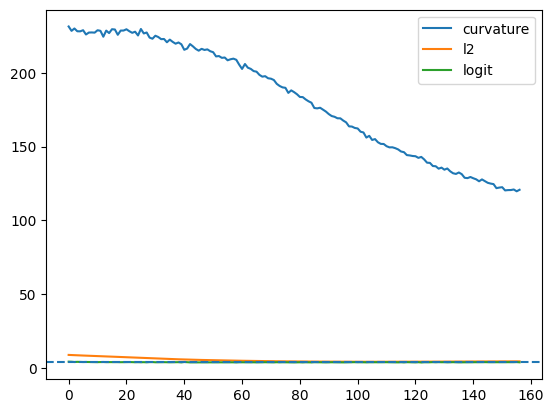

100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


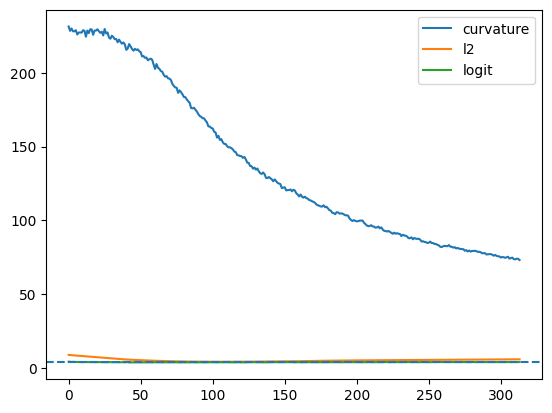

100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


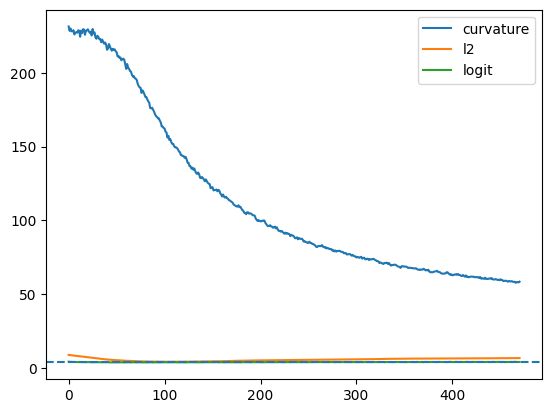

100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


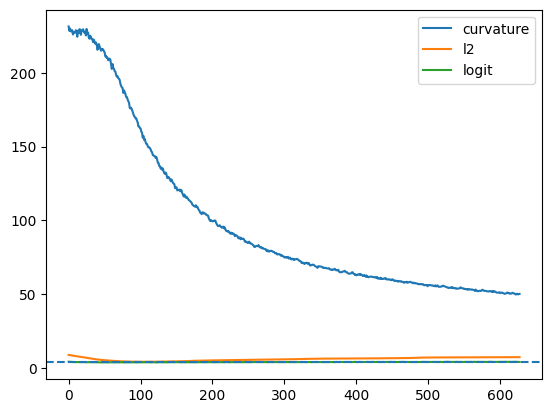

100%|██████████| 157/157 [03:03<00:00,  1.17s/it]


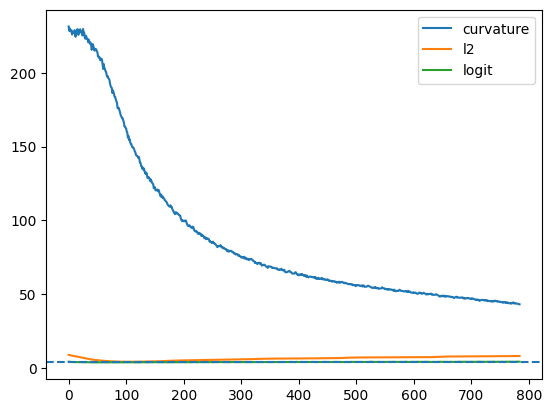

In [63]:
# perturbation_matrix = torch.randn((perturb_ctx_len, embedding_dim, embedding_dim), device=device) * 0.001
perturbation_matrix = torch.randn((embedding_dim, embedding_dim), device=device) * 0.001
perturbation_matrix.requires_grad = True

# success!
# epochs = 5
# optimizer = torch.optim.Adam([perturbation_matrix], lr=1e-4)
# l2_lambda = 2

# total_steps = len(trainloader) * epochs
# curve_loss_lambda = lambda step: math.exp((1/2) * (step / total_steps)) - 1

# logit_lambda = 30

epochs = 3
optimizer = torch.optim.Adam([perturbation_matrix], lr=1e-4)
l2_lambda = 2

total_steps = len(trainloader) * epochs
curve_loss_lambda = lambda step: math.exp((1/2) * (step / total_steps)) - 1

logit_lambda = 30

def perturb(input, layer_num, token):
    #input: (batch_size, embedding_dim)
    #perturbation_matrix: (perturb_ctx_len, embedding_dim, embedding_dim)
    #want: (batch_size, embedding_dim)
    # perturbation = torch.matmul(input, perturbation_matrix[token, :, :])
    perturbation = torch.matmul(input, perturbation_matrix)
    return perturbation

perturbation_dict = {perturb_layer: [(hook_location, perturb_tokens, perturb)]}
register_pertubation_hooks(model, perturbation_dict, device)

model.to(device)
model.set_hooks()
model.eval()

curvature_losses = []
l2_losses = []
logit_losses = []
starting_logit_loss = 0

for epoch in range(epochs):
    for i, batch in enumerate(tqdm(trainloader)):
        outputs = model.forward_with_extra_loss(batch["input_ids"].to(device), labels=batch["labels"].to(device))
        logit_loss = outputs.loss

        optimizer.zero_grad()

        losses = model.output_extra_losses()
        curvature_loss = 0
        for loss in losses.values():
            if loss is not None:
                curvature_loss += loss
                        
        l2_loss = torch.norm(perturbation_matrix, p=2)
        loss = l2_loss + curvature_loss * curve_loss_lambda(i+(epoch*len(trainloader))) + logit_loss * logit_lambda

        if len(logit_losses) == 0:
            starting_logit_loss = logit_loss.item()

        curvature_losses.append(curvature_loss.item())
        l2_losses.append(l2_loss.item())
        logit_losses.append(logit_loss.item())

        loss.backward()
        optimizer.step()

        # if i % 30 == 0:
        #     print(f"Loss: {loss.item()}")

    plt.plot(curvature_losses, label="curvature")
    plt.plot(l2_losses, label="l2")
    plt.plot(logit_losses, label="logit")
    plt.axhline(y=starting_logit_loss, linestyle="--")
    plt.legend()
    plt.show()

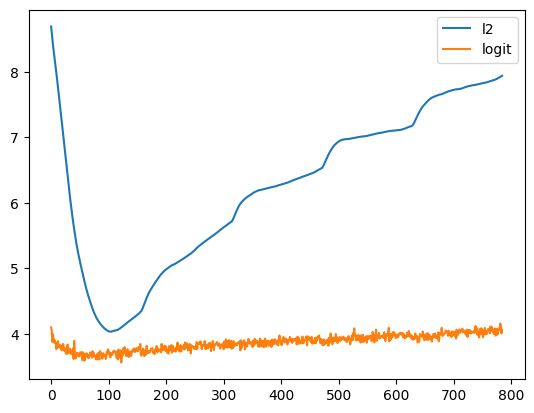

In [64]:
# plt.plot(curvature_losses, label="curvature")
plt.plot(l2_losses, label="l2")
plt.plot(logit_losses, label="logit")
plt.legend()
plt.show()

In [65]:
#compare normal model to perturbed model
normal_model = GPT2LMHeadModel.from_pretrained('gpt2')
normal_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [66]:
#generate some sentences from both models
normal_model.eval()
model.eval()

def generate_sentence(model, tokenizer, index=19, max_length=45):
    # input_ids = tokenizer.encode("The quick brown fox jumps over the lazy dog", return_tensors='pt').to(device)
    input_ids = torch.tensor(data[index]).unsqueeze(0).to(device)
    input_ids = input_ids[:, :5]
    output = tokenizer.decode(model.generate(input_ids, max_length=max_length, do_sample=True, pad_token_id=tokenizer.eos_token_id)[0])
    # print(output)
    
    for i in range(max_length):
        output = model(input_ids, return_dict=True)
        logits = output.logits
        next_token = torch.argmax(logits[:, -1, :])
        input_ids = torch.cat([input_ids, next_token.unsqueeze(0).unsqueeze(0)], dim=1)

    return input_ids[0, :]

print("Normal model:")
print(tokenizer.decode(generate_sentence(normal_model, tokenizer), skip_special_tokens=True))
print("Perturbed model:")
print(tokenizer.decode(generate_sentence(model, tokenizer), skip_special_tokens=True))

Normal model:
 Japan where he discussed the issue with his wife, who was also present.

"I'm not going to talk about it," he said. "I'm not going to talk about it. I'm not going to talk about it. I
Perturbed model:
 Japan where he discussed the possibility of a "new" world order.
= = = =
= = =
= = =
= = =
= = =
= = =
= = =
= = =
= =


In [67]:
def evaluate(model, valloader):
    model.eval()
    losses = []
    for step, batch in tqdm(enumerate(valloader), total=len(valloader)):
        with torch.no_grad():
            inputs = batch["input_ids"].to(device)
            if "attention_mask" in batch:
                attention_mask = batch["attention_mask"].to(device)
            else:
                attention_mask = None
            labels = batch["labels"].to(device)
            outputs = model(inputs, labels=labels, attention_mask=attention_mask)
        losses.append(outputs.loss)
    loss = torch.mean(torch.stack(losses))
    return loss.item()

In [68]:
evaluate(model, valloader)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


4.082069396972656

In [69]:
evaluate(normal_model, valloader)

100%|██████████| 40/40 [00:11<00:00,  3.54it/s]


4.078111171722412

100%|██████████| 50/50 [00:00<00:00, 131.77it/s]
50it [00:00, 71.60it/s]
100%|██████████| 50/50 [00:00<00:00, 124.35it/s]
50it [00:00, 70.58it/s]


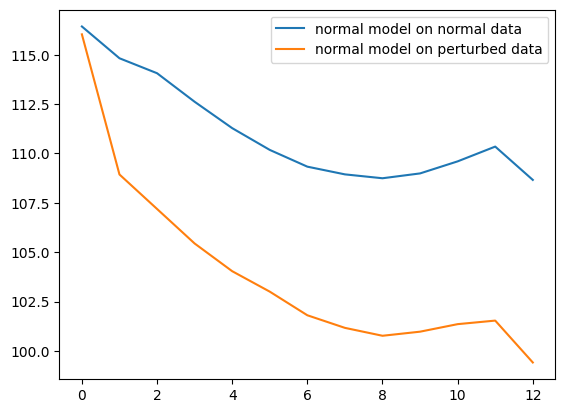

100%|██████████| 50/50 [00:00<00:00, 70.87it/s]
50it [00:00, 76.83it/s]
100%|██████████| 50/50 [00:00<00:00, 67.25it/s]
50it [00:00, 70.86it/s]


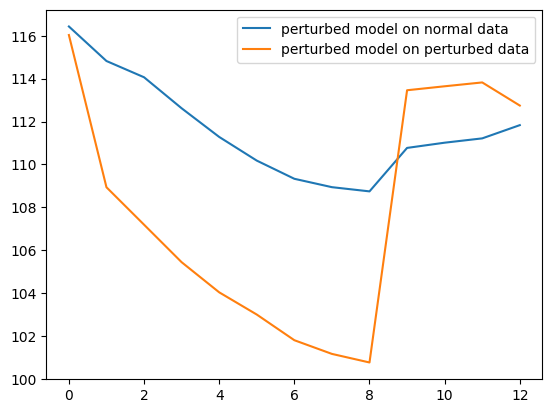

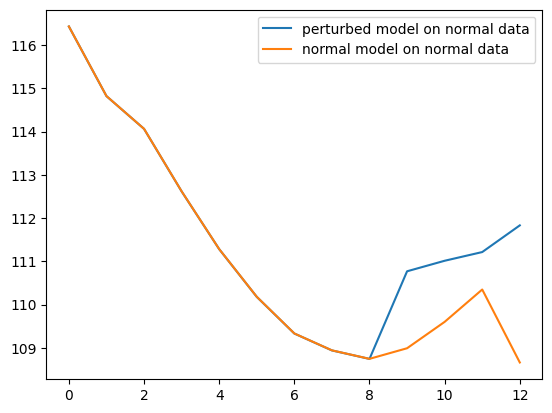

In [70]:
normal_sentences = []
perturbed_sentences = []

for i in range(50, 100):
    normal_sentences.append(generate_sentence(normal_model, tokenizer, i))
    perturbed_sentences.append(generate_sentence(model, tokenizer, i))

activations = compute_model_activations(normal_model, normal_sentences, device)
normalmodel_on_normaldata_curvature = compute_model_curvature(activations)

activations = compute_model_activations(normal_model, perturbed_sentences, device)
normalmodel_on_perturbeddata_curvature = compute_model_curvature(activations)

plt.plot(np.mean(normalmodel_on_normaldata_curvature["curve"] * 180 / np.pi, axis=1), label="normal model on normal data")
plt.plot(np.mean(normalmodel_on_perturbeddata_curvature["curve"] * 180 / np.pi, axis=1), label="normal model on perturbed data")
plt.legend()
plt.show()

activations = compute_model_activations(model, normal_sentences, device)
perturbedmodel_on_normaldata_curvature = compute_model_curvature(activations)

activations = compute_model_activations(model, perturbed_sentences, device)
perturbedmodel_on_perturbeddata_curvature = compute_model_curvature(activations)

plt.plot(np.mean(perturbedmodel_on_normaldata_curvature["curve"] * 180 / np.pi, axis=1), label="perturbed model on normal data")
plt.plot(np.mean(perturbedmodel_on_perturbeddata_curvature["curve"] * 180 / np.pi, axis=1), label="perturbed model on perturbed data")
plt.legend()
plt.show()

plt.plot(np.mean(perturbedmodel_on_normaldata_curvature["curve"] * 180 / np.pi, axis=1), label="perturbed model on normal data")
plt.plot(np.mean(normalmodel_on_normaldata_curvature["curve"] * 180 / np.pi, axis=1), label="normal model on normal data")
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 39.30it/s]
50it [00:01, 30.30it/s]
100%|██████████| 50/50 [00:00<00:00, 118.83it/s]
50it [00:01, 30.23it/s]


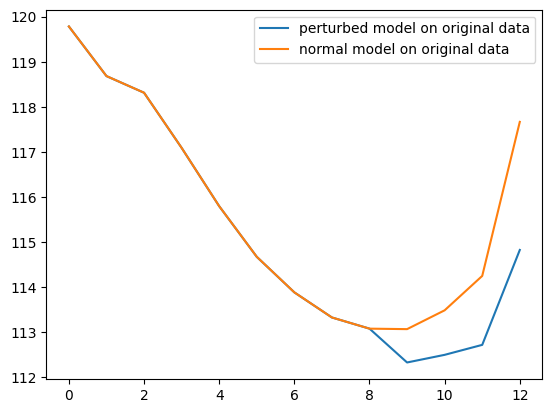

In [71]:
original_data = data[:50]

activations = compute_model_activations(model, original_data, device)
perturbed = compute_model_curvature(activations)

activations = compute_model_activations(normal_model, original_data, device)
normal = compute_model_curvature(activations)

plt.plot(np.mean(perturbed["curve"] * 180 / np.pi, axis=1), label="perturbed model on original data")
plt.plot(np.mean(normal["curve"] * 180 / np.pi, axis=1), label="normal model on original data")
plt.legend()
plt.show()

# Making a matrix of perturbations found with perturbation matrix

In [77]:
path = "/om2/user/jackking/modular_transformers/scripts/dimensionality_reduction"
datatype = "natural_language"
val_data = pickle.load(open(f"{path}/data/{datatype}/valid_data_natural.pkl", 'rb'))
ctx_len = len(val_data[0])
valset = LMDataset(val_data, labels=val_data)
batch_size = 64
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)

torch.cuda.empty_cache()

In [78]:
recorded_perturbations = np.zeros((len(val_data), ctx_len, embedding_dim))
batch_index = np.zeros(1)

def record_perturb(input, layer_num, token):
    #input: (batch_size, embedding_dim)
    #perturbation_matrix: (perturb_ctx_len, embedding_dim, embedding_dim)
    #want: (batch_size, embedding_dim)
    global batch_index
    # perturbation = torch.matmul(input, perturbation_matrix[token, :, :])
    perturbation = torch.matmul(input, perturbation_matrix)

    recorded_perturbations[int(batch_index[0]*batch_size):int(batch_index[0]+1)*batch_size, token, :] = perturbation.cpu().detach().numpy()
    if token == ctx_len-1:
        batch_index[0] += 1
    return 0

perturbation_dict = {perturb_layer: [(hook_location, perturb_tokens, record_perturb)]}
register_pertubation_hooks(model, perturbation_dict, device)

model.eval()
for i, batch in enumerate(tqdm(valloader)):
    outputs = model(batch["input_ids"].to(device), labels=batch["labels"].to(device))


100%|██████████| 79/79 [00:13<00:00,  5.70it/s]


In [109]:
#labels are position in sentence
y = []
for i in range(len(val_data["inputs"])):
    y.append(np.arange(ctx_len))
y = np.array(y).reshape(-1)

#bucket it into 16 bins
# y = np.floor(y / (ctx_len / 16))

recorded_perturbations = recorded_perturbations.reshape(-1, embedding_dim)
np.save(f"{path}/data/{datatype}/recorded_perturbations.npy", recorded_perturbations)

<Axes: title={'center': 'PCA Component Explained Variances'}, xlabel='First n principal components', ylabel='Explained variance ratio of first n components'>

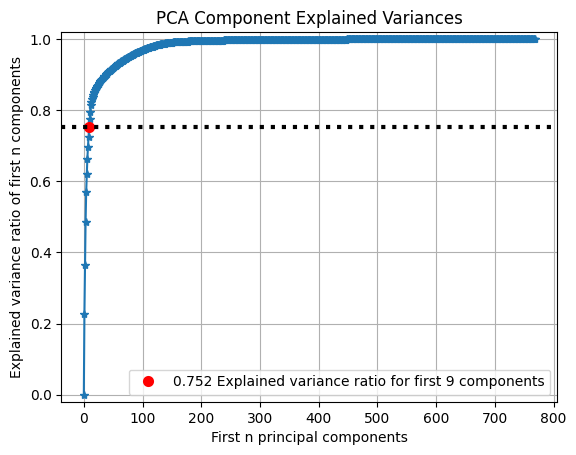

In [80]:
pca = PCA()
pca.fit(recorded_perturbations)
plot_pca_component_variance(pca)

<Axes: title={'center': 'PCA 2-D Projection'}, xlabel='First Principal Component', ylabel='Second Principal Component'>

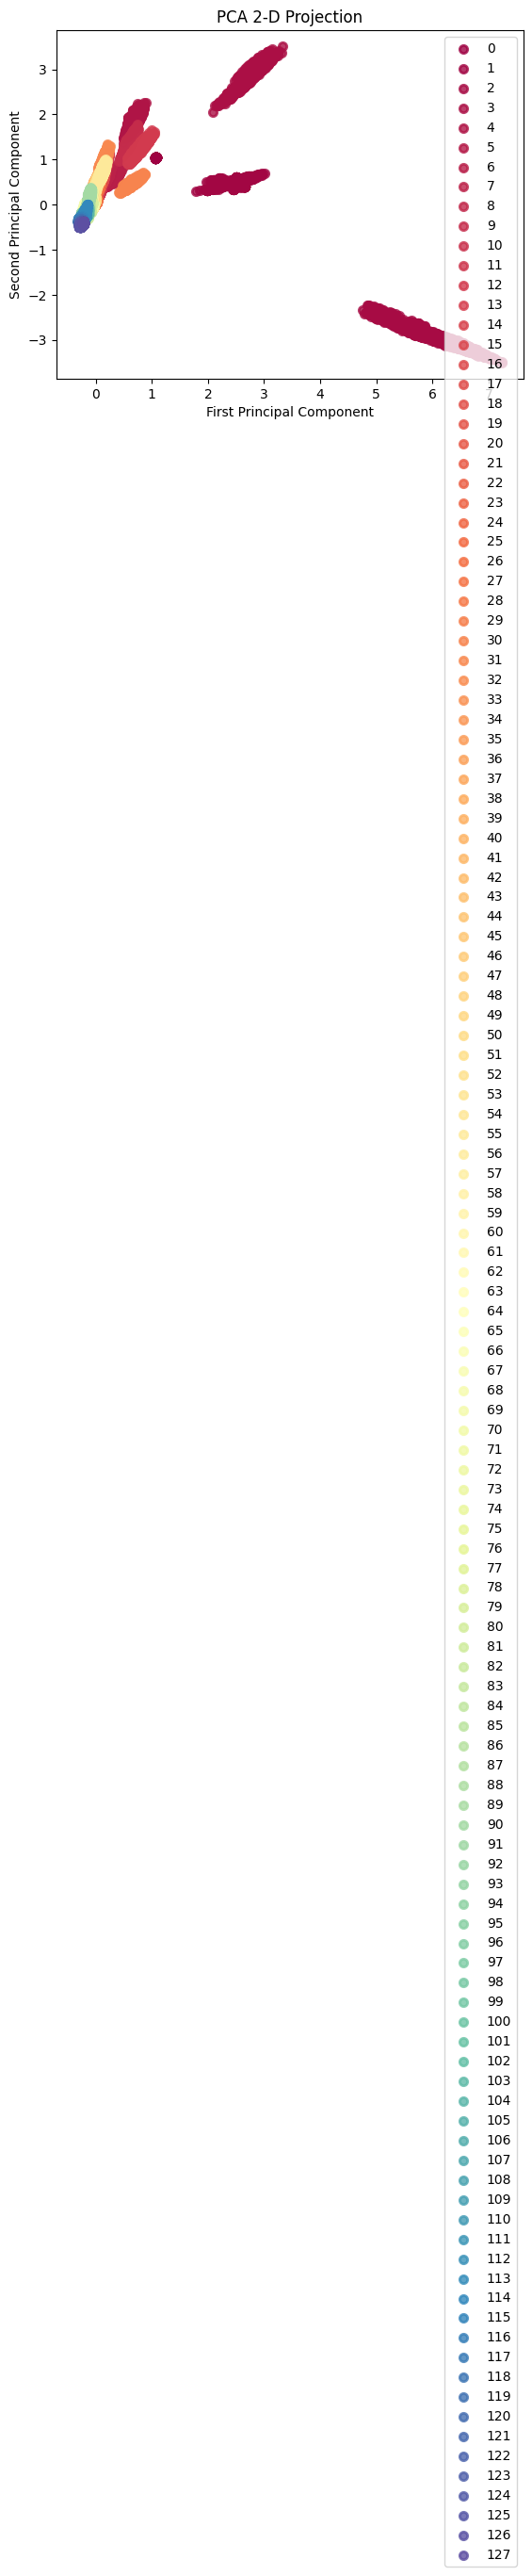

In [111]:
plot_pca_2d_projection(pca, recorded_perturbations, y=y)